In [1]:
#importing rquired packages
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

In [34]:
# setting gpu device
torch.cuda.set_device(1)
torch.__version__

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


#Check GPU support, please do activate GPU
print(torch.cuda.current_device())
print(torch.cuda.is_available())
torch.cuda.get_device_name(torch.cuda.current_device())

Using device: cuda
NVIDIA GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
1
True


'NVIDIA GeForce GTX 1080 Ti'

# Load Data

The Plant Village Dataset can be found [here](https://drive.google.com/file/d/1I31OfPJpczFw88XncMXmo1YnWIsqn9lS/view?usp=sharing) or [here](https://data.mendeley.com/datasets/tywbtsjrjv/1)

In [35]:
#Organizing the dataset
data_dir = '/home/SharedData/Siddharth/PlantVillage'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
nThreads = 4
batch_size = 32
use_gpu = torch.cuda.is_available()

import json

with open('categories.json', 'r') as f:
    cat_to_name = json.load(f)

# Define your transforms for the training and validation sets
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(256),
        #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [36]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

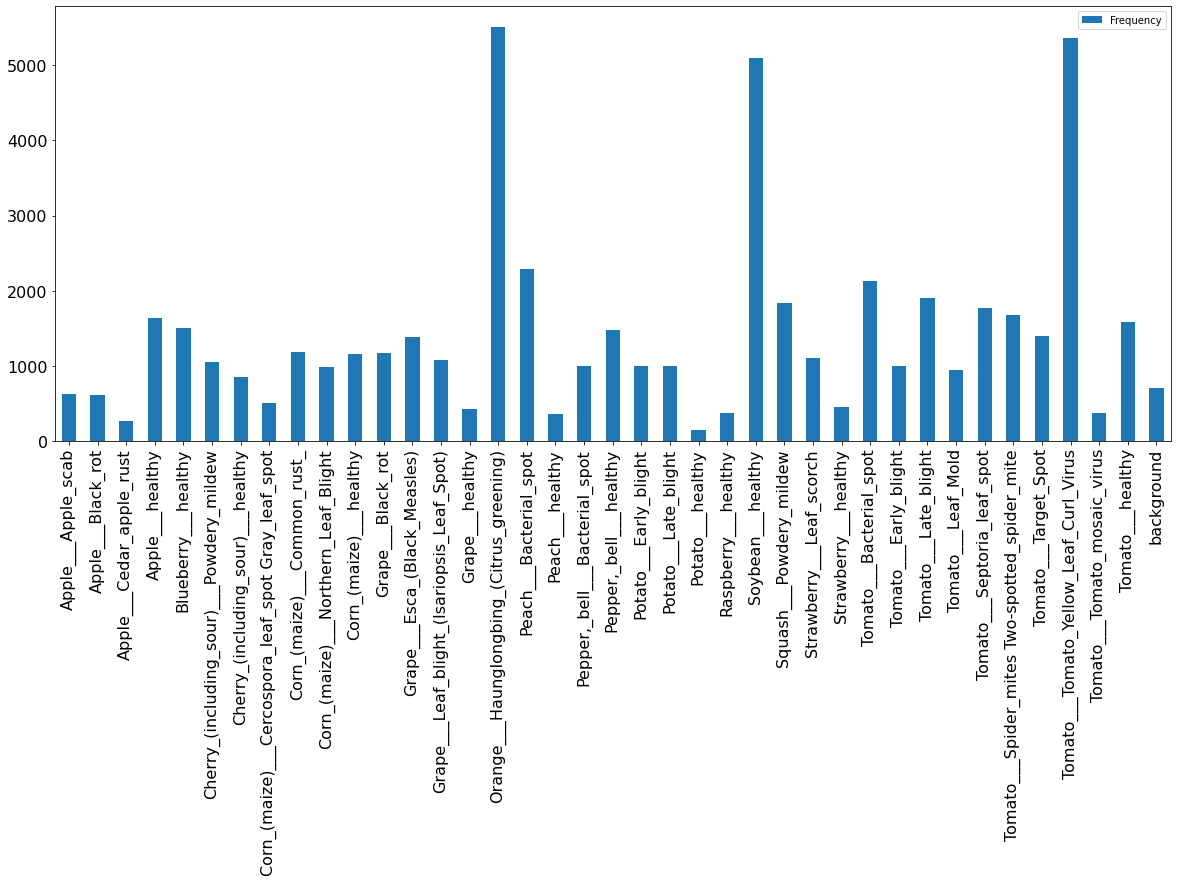

In [37]:
from collections import Counter
import pandas as pd

counts = Counter(image_datasets['train'].targets)
df = pd.DataFrame(columns=['Frequency'])

for i in counts:
    df.loc[class_names[i]] = counts[i]

counts = Counter(image_datasets['val'].targets)

for i in counts:
    df.loc[class_names[i]] = df.loc[class_names[i]] + counts[i]

df.plot.bar(figsize=(20, 8))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

# Train

## Load Pre-Trained Model

In [38]:
# turning gradients off or on depending on feature extracting or not
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [39]:
# adding a linear block on top of the baseline models
def final_classifier(num_ftrs,num_classes):
  return nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(num_ftrs, 512)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(512, num_classes)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# initializing the baseline model
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet152":
        """ Resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        print(num_ftrs)
        model_ft.fc = final_classifier(num_ftrs,num_classes)
        input_size = 224
    
    elif model_name == "resnet18":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        print(num_ftrs)
        model_ft.fc = final_classifier(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        print(num_ftrs)
        model_ft.fc = final_classifier(num_ftrs,num_classes)
        input_size = 224
    
    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        print(num_ftrs)
        model_ft.classifier[6] = final_classifier(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        print(num_ftrs)
        model_ft.classifier[6] = final_classifier(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = 512
        print(num_ftrs)
        model_ft.classifier[1] = nn.Sequential(OrderedDict([nn.Conv2d(num_ftrs, 512, kernel_size=(1,1), stride=(1,1)),('relu', nn.ReLU()),
                                                            ('fc2', nn.Linear(512, num_classes)),('output', nn.LogSoftmax(dim=1))]))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        print(num_ftrs)
        model_ft.classifier = final_classifier(num_ftrs,num_classes)
        input_size = 224
    
    elif model_name == "efficientnet":
        """ Densenet
        """
        model_ft = models.efficientnet_b7(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        print(num_ftrs)
        model_ft.classifier[1] = final_classifier(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        print(num_ftrs)
        model_ft.AuxLogits.fc = final_classifier(num_ftrs,num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        print(num_ftrs)
        model_ft.fc = final_classifier(num_ftrs,num_classes)
        input_size = 299
    
    elif model_name == 'mobilenet':
        model_ft = models.mobilenet_v2(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        print(num_ftrs)
        model_ft.classifier[1] = final_classifier(num_ftrs,num_classes)
        input_size = 224
    # elif model_name == 'googlenet':
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [40]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "densenet"

# Number of classes in the dataset
num_classes = 39

# Number of epochs to train for
num_epochs = 10

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

In [41]:
# Initialize the model for this run
model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

1024


In [42]:
# calculating the size of the model
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 28.925MB


In [ ]:
# Print the model we just instantiated
print(model)

## Train Model

Notice that there are different training loops and their respective calls for fine tuning and feature extracting so only execute the one which you want to perform
### Fine-tuning

In [44]:
from collections import OrderedDict
from tqdm.notebook import tqdm
#Function to train the model
def train_model(model, criterion, optimizer1, optimizer2, scheduler1, scheduler2, num_epochs=20,is_inception=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:       
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            repeat = 0
            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer1.zero_grad()
                optimizer2.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    if (is_inception and phase == 'train'):
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else :
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer2.step()

                        # updating the baseline model weigths only after every 20 batches
                        if (repeat % 20 == 0):
                            optimizer1.step()
                        
                        repeat = repeat + 1
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        scheduler1.step()
        scheduler2.step()
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Train a model with a pre-trained network
num_epochs = 20
if use_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()

# NLLLoss because our output is LogSoftmax
criterion = nn.NLLLoss()

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
size_gen = sum(1 for _ in params_to_update)

print("Params to learn:")
if feature_extract:
    params_to_update = []
    names_last_layers = []
    names_initial_layers = []
    params_initial_layers = []
    params_last_layers = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    names_last_layers = []
    names_initial_layers = []
    params_initial_layers = []
    params_last_layers = []
    for index,(name,param) in enumerate(model.named_parameters()):
        if param.requires_grad == True:
            if (index < size_gen - 4):
                names_initial_layers.append(name)
                params_initial_layers.append(param)
            else:
                names_last_layers.append(name)
                params_last_layers.append(param)

# Observe that all parameters are being optimized

print(names_initial_layers)
print(names_last_layers)

optimizer1 = optim.Adam(params_initial_layers, lr=0.0001)
optimizer2 = optim.Adam(params_last_layers,lr=0.0001)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler1 = lr_scheduler.StepLR(optimizer1, step_size=5, gamma=0.1)
exp_lr_scheduler2 = lr_scheduler.StepLR(optimizer2, step_size=5, gamma=0.1)


model_ft = train_model(model, criterion, optimizer1 , optimizer2 , exp_lr_scheduler1 ,exp_lr_scheduler2, num_epochs=15,is_inception=False)

### Feature Extracting

In [ ]:
from collections import OrderedDict
from tqdm.notebook import tqdm
#Function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=20,is_inception=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    if (is_inception and phase == 'train'):
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else :
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        scheduler.step()
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Train a model with a pre-trained network
num_epochs = 10
if use_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()

# NLLLoss because our output is LogSoftmax
criterion = nn.NLLLoss()

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = []

print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized

optimizer = optim.Adam(params_to_update, lr=0.01)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=15,is_inception=False)

# Test Model

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

def test(model, dataloaders, device):
  y_pred = []
  y_true = []
  
  model.eval()
  accuracy = 0
  
  model.to(device)
    
  for images, labels in dataloaders['val']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    output = ps.max(1)[1].data.cpu().numpy()

    y_pred.extend(output)
    y_true.extend(labels.data.cpu().numpy())

    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()
      
  print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['val'])))

  classes = tuple(class_names)

  # Build confusion matrix
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in classes],
                      columns = [i for i in classes])
  plt.figure(figsize = (20,20))
  sn.heatmap(df_cm, annot=True)
  plt.show()

Testing Accuracy: 0.954


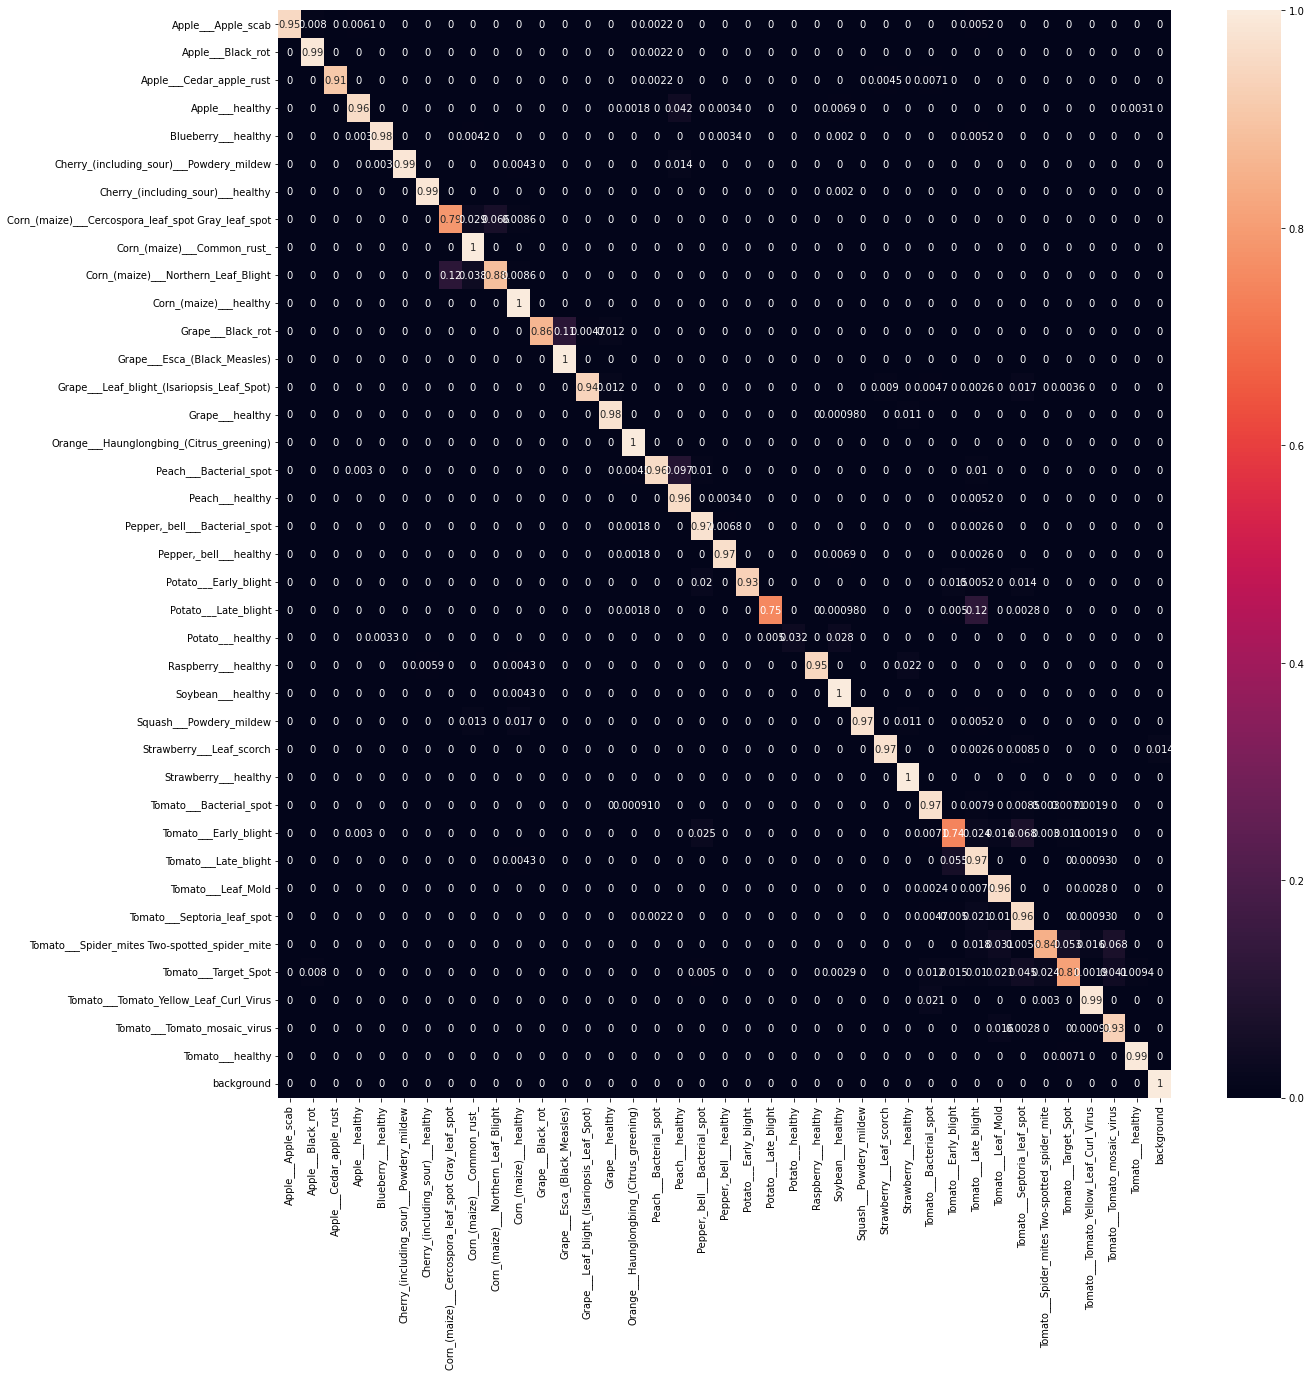

In [16]:
test(model_ft, dataloaders, device)

# Save Model

In [46]:
#change path to select where model is saved
torch.save(model_ft.state_dict(),"/home/SharedData/Siddharth/models/plantvillage_full_densenet_2.pth")

# Load Model

In [ ]:
model_to_load = 'densenet'
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model,initial_size = initialize_model(model_to_load,39,feature_extract=False,use_pretrained=True)
    
    model.load_state_dict(checkpoint)
    model.to(device)
    
    return model, checkpoint

# Get index to class mapping
loaded_model, _ = load_checkpoint('/home/SharedData/Siddharth/models/plantvillage_full_'+model_to_load+'.pth')

In [ ]:
test(loaded_model, dataloaders, device)

# Visualise Predictions

In [1]:
idx_to_class = ["Apple___Apple_scab",
            "Apple___Black_rot",
            "Apple___Cedar_apple_rust",
            "Apple___healthy",
            "Blueberry___healthy",
            "Cherry_(including_sour)___Powdery_mildew",
            "Cherry_(including_sour)___healthy",
            "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
            "Corn_(maize)___Common_rust_",
            "Corn_(maize)___Northern_Leaf_Blight",
            "Corn_(maize)___healthy",
            "Grape___Black_rot",
            "Grape___Esca_(Black_Measles)",
            "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
            "Grape___healthy",
            "Orange___Haunglongbing_(Citrus_greening)",
            "Peach___Bacterial_spot",
            "Peach___healthy",
            "Pepper,_bell___Bacterial_spot",
            "Pepper,_bell___healthy",
            "Potato___Early_blight",
            "Potato___Late_blight",
            "Potato___healthy",
            "Raspberry___healthy",
            "Soybean___healthy",
            "Squash___Powdery_mildew",
            "Strawberry___Leaf_scorch",
            "Strawberry___healthy",
            "Tomato___Bacterial_spot",
            "Tomato___Early_blight",
            "Tomato___Late_blight",
            "Tomato___Leaf_Mold",
            "Tomato___Septoria_leaf_spot",
            "Tomato___Spider_mites Two-spotted_spider_mite",
            "Tomato___Target_Spot",
            "Tomato___Tomato_Yellow_Leaf_Curl_Virus",
            "Tomato___Tomato_mosaic_virus",
            "Tomato___healthy",
            "background"]

In [25]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model

    size = 256, 256
    image.thumbnail(size, Image.ANTIALIAS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255.
        
    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]
    
    imgA = (imgA - 0.485)/(0.229) 
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)
        
    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC
    
    npImage = np.transpose(npImage, (2,0,1))
    
    return npImage


def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Implement the code to predict the class from an image file
    
    image = torch.FloatTensor([process_image(Image.open(image_path))])
    model.eval()
    image = Variable(image)
    image = image.to(device)
    output = model.forward(image)
    probabilities = torch.exp(output).cpu().data.numpy()[0]
    

    top_idx = np.argsort(probabilities)[-topk:][::-1]
    print(top_idx)
    top_class = [idx_to_class[x] for x in top_idx]
    top_probability = probabilities[top_idx]

    return top_probability, top_class


def view_classify(img, probabilities, classes, mapper, inDataset=True):
    ''' Function for viewing an image and it's predicted classes.
    '''
    img_filename = img.split('/')[-2]
    img = Image.open(img)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    if inDataset:
      flower_name = mapper[img_filename]
      ax1.set_title(flower_name)
    
    ax1.imshow(img)
    ax1.axis('off')
    
    y_pos = np.arange(len(probabilities))
    ax2.barh(y_pos, probabilities)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([mapper[x] for x in classes])
    ax2.invert_yaxis()

In [ ]:
img = '/home/SharedData/Siddharth/PlantVillage/val/Strawberry___Leaf_scorch/1a123c2f-bdb0-4b73-91ce-84284b211edd___RS_L.Scorch 1468.JPG'
torch.cuda.empty_cache()
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

# GradCAM Visualisation

Refer to the [link](https://github.com/jacobgil/pytorch-grad-cam.git) for Gradcam visulization

In [25]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [ ]:
target_layers = [loaded_model.layer4[-1]]

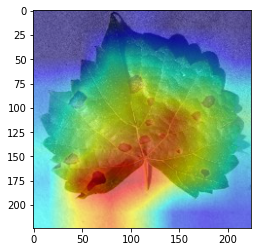

In [ ]:
image_path = '/content/apple_black_rot.jpg'
input_tensor = torch.FloatTensor([process_image(Image.open(image_path))])

cam = GradCAM(model=loaded_model, target_layers=target_layers, use_cuda=True)

targets = [ClassifierOutputTarget(11)]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

grayscale_cam = grayscale_cam[0, :]

visualization = show_cam_on_image(np.asarray(Image.open(image_path).resize((224, 224)))/255., grayscale_cam, use_rgb=True)
plt.imshow(visualization)

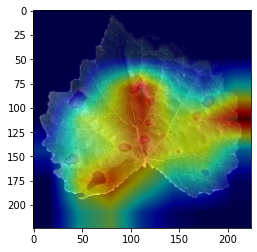

In [ ]:
image_path = '/content/apple_black_rot_marked.jpg'
input_tensor = torch.FloatTensor([process_image(Image.open(image_path))])

cam = GradCAM(model=loaded_model, target_layers=target_layers, use_cuda=True)

targets = [ClassifierOutputTarget(11)]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

grayscale_cam = grayscale_cam[0, :]

visualization = show_cam_on_image(np.asarray(Image.open(image_path).resize((224, 224)))/255., grayscale_cam, use_rgb=True)
plt.imshow(visualization)

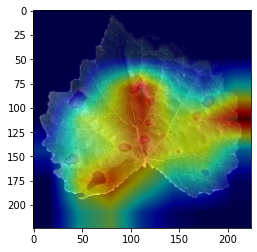

In [ ]:
image_path = '/content/apple_black_rot_marked.jpg'
input_tensor = torch.FloatTensor([process_image(Image.open(image_path))])

cam = GradCAM(model=loaded_model, target_layers=target_layers, use_cuda=True)

targets = [ClassifierOutputTarget(11)]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

grayscale_cam = grayscale_cam[0, :]

visualization = show_cam_on_image(np.asarray(Image.open(image_path).resize((224, 224)))/255., grayscale_cam, use_rgb=True)
plt.imshow(visualization)

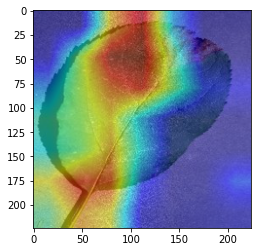

In [ ]:
image_path = 'PlantVillage/val/Apple___Black_rot/0139bc6d-391c-4fd1-bcae-cc74dabfddd7___JR_FrgE.S 2734.JPG'
input_tensor = torch.FloatTensor([process_image(Image.open(image_path))])

cam = GradCAM(model=loaded_model, target_layers=target_layers, use_cuda=True)

targets = [ClassifierOutputTarget(1)]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

grayscale_cam = grayscale_cam[0, :]

visualization = show_cam_on_image(np.asarray(Image.open(image_path).resize((224, 224)))/255., grayscale_cam, use_rgb=True)
plt.imshow(visualization)

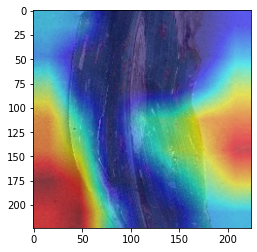

In [ ]:
image_path = 'PlantVillage/val/Corn_(maize)___Northern_Leaf_Blight/00a14441-7a62-4034-bc40-b196aeab2785___RS_NLB 3932.JPG'
input_tensor = torch.FloatTensor([process_image(Image.open(image_path))])

cam = GradCAM(model=loaded_model, target_layers=target_layers, use_cuda=True)

targets = [ClassifierOutputTarget(9)]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

grayscale_cam = grayscale_cam[0, :]

visualization = show_cam_on_image(np.asarray(Image.open(image_path).resize((224, 224)))/255., grayscale_cam, use_rgb=True)
plt.imshow(visualization)

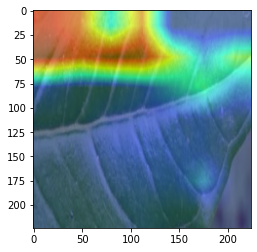

In [ ]:
image_path = '/content/given_images/pomegranate (5).jpeg'
input_tensor = torch.FloatTensor([process_image(Image.open(image_path))])

cam = GradCAM(model=loaded_model, target_layers=target_layers, use_cuda=True)

targets = [ClassifierOutputTarget(10)]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

grayscale_cam = grayscale_cam[0, :]

visualization = show_cam_on_image(np.asarray(Image.open(image_path).resize((224, 224)))/255., grayscale_cam, use_rgb=True)
plt.imshow(visualization)

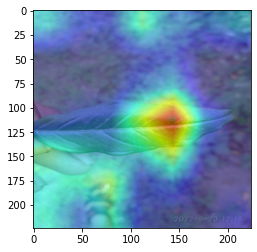

In [ ]:
image_path = '/content/given_images/pomegranate (4).jpeg'
input_tensor = torch.FloatTensor([process_image(Image.open(image_path))])

cam = GradCAM(model=loaded_model, target_layers=target_layers, use_cuda=True)

targets = [ClassifierOutputTarget(30)]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

grayscale_cam = grayscale_cam[0, :]

visualization = show_cam_on_image(np.asarray(Image.open(image_path).resize((224, 224)))/255., grayscale_cam, use_rgb=True)
plt.imshow(visualization)